# Linear Regression Implementation

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy
from scipy import linalg # QR DECOMPOSITION

# Utility Functions

## Metrics

In [2]:
def get_mse(y_real, y_pred):
    return np.mean((y_real - y_pred) ** 2)

def get_rmse(y_real, y_pred):
    return np.sqrt(get_mse(y_real, y_pred))

## Standardization

In [3]:
class StandardScaler:
    def __init__(self):
        self.fitted = False

    def fit_transform(self, data):      
        self.mean = data.mean(axis=0)
        self.std = data.std(axis=0)
        self.fitted = True

        scaled_data = (data - self.mean) / self.std
        return scaled_data
    
    def transform(self, data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')

        scaled_data = (data - self.mean) / self.std
        return scaled_data

    def inverse_transform(self, scaled_data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')
        
        original_data = (scaled_data * self.std) + self.mean
        return original_data


## Min-max feature scaling

In [4]:
class MinMaxScaler:
    def __init__(self):
        self.fitted = False

    def fit_transform(self, data):      
        self.maximum = data.max(axis=0)
        self.minimum = data.min(axis=0)
        self.fitted = True

        scaled_data =  (data - self.minimum) / (self.maximum - self.minimum)
        return scaled_data
    
    def transform(self, data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')

        scaled_data =  (data - self.minimum) / (self.maximum - self.minimum)
        return scaled_data

    def inverse_transform(self, scaled_data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')
        
        original_data = (self.maximum - self.minimum) * scaled_data + self.minimum
        return original_data

# Linear Regression

In [5]:
data = np.genfromtxt('../data/artificial1d.csv', delimiter=',')
data[:5,:]

array([[-1.        , -2.08201726],
       [-0.93103448, -1.32698023],
       [-0.86206897, -1.10559772],
       [-0.79310345, -0.87394576],
       [-0.72413793, -0.28502695]])

## My Linear Regression

In [6]:
class MyLinearRegression:
    def __init__(self):
        self.fitted = False

    # Fit with OLS
    def fit_ols(self, X, y):
        matrix_to_mitigate_numerical_problems = (10 ** -8) * np.eye(X.shape[1], X.shape[1])
        w_hat = (np.linalg.pinv(X.T @ X + matrix_to_mitigate_numerical_problems) @ X.T) @ y
        self.w = w_hat.reshape(-1, 1)
        self.fitted = True

    # Fit with OLS using QR Decomposition
    def fit_ols_with_qr_decomp(self, X, y):
        Q, R = np.linalg.qr(X) 
        right_side_of_equation = Q.T @ y
        self.w = scipy.linalg.solve_triangular(R, right_side_of_equation)
        self.fitted = True


    # Fit with gradient descent
    def fit_gd(self, X, y, alpha=0.01, n_iterations=1000, random_state=151477):
        self.fitted = True
        
        rnd = np.random.RandomState(random_state)
        self.w = rnd.uniform(0, 1, X.shape[1]).reshape(-1, 1)        
        self.learning_curve = []

        for i in range(n_iterations):
            y_pred = self.predict(X)
            e = (y - y_pred) 
            self.w = self.w + ((1/len(y)) * alpha * (e.T @ X)).reshape(-1, 1)
            
            y_pred = self.predict(X)
            self.learning_curve.append(get_mse(y, y_pred))


    # Fit with stochastic gradient descent
    def fit_sgd(self, X, y, alpha=0.01, n_iterations=1000, random_state=151477):
        self.fitted = True
        
        rnd = np.random.RandomState(random_state)
        self.w = rnd.uniform(0, 1, X.shape[1]).reshape(-1, 1)

        self.learning_curve = []
        for i in range(n_iterations):
            
            chosen_index = rnd.randint(0, X.shape[0])
            random_X = X[[chosen_index]]
            random_y = y[[chosen_index]]

            y_pred = self.predict(random_X)
            e = (random_y - y_pred)
            self.w = self.w + (alpha * (e.T * random_X)).reshape(-1, 1)

            self.learning_curve.append(get_mse(y, self.predict(X)))

    
    def predict(self, X):
        if self.fitted:
            return (X @ self.w).reshape(-1, 1)
        else:
            raise Exception('Model not fitted!')


    def print_parameters(self):
        if self.fitted:
            for i in range(len(self.w)):
                if i == 0:
                    print('Intercept:\t{:.6f}'.format(self.w[i, 0]))
                else:
                    print('X({}):    \t{:.6f}'.format(i, self.w[i, 0]))
        else:
            raise Exception('Model not fitted!')


## Item a) OLS
Show the model parameters and the MSE (Mean Squared Error) obtained by OLS (Ordinary Least Squares) method. Plot the result line over the data.

In [7]:
X = np.hstack([np.ones((len(data), 1)), data[:,[0]]])
y = data[:,[1]]

In [8]:
my_lr = MyLinearRegression()
my_lr.fit_ols(X, y) # OLS
y_pred = my_lr.predict(X)

my_lr.print_parameters()

print('\n#--- Metrics ---#')
print('MSE:', get_mse(y, y_pred))
print('RMSE:', get_rmse(y, y_pred))


Intercept:	0.067618
X(1):    	1.574865

#--- Metrics ---#
MSE: 0.2134009013293699
RMSE: 0.461953354062258


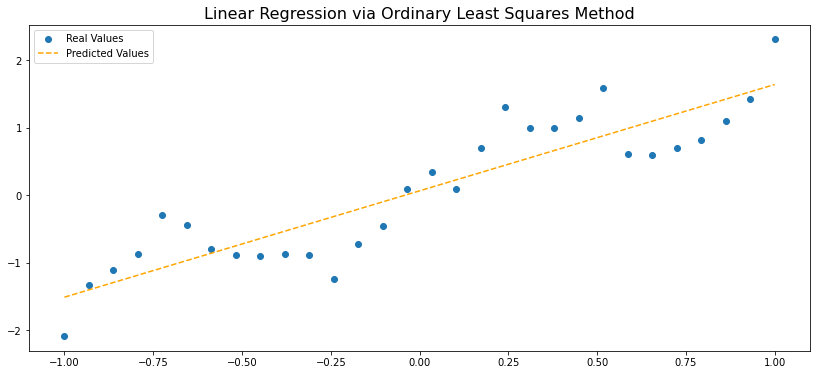

In [9]:
fig = plt.figure(figsize=(14, 6))
plt.title('Linear Regression via Ordinary Least Squares Method', fontsize=16)
plt.scatter(X[:, 1], y, label = 'Real Values')
plt.plot(X[:, 1], y_pred, c='orange', linestyle='--', label = 'Predicted Values')
plt.legend()
plt.show()

### OLS with QR Decomposition
When m $\gg$ n, we can use QR Decomposition to mitigate numerical problems of matrix inversion in standard formula of OLS (Normal Equation). $\\$
Doing the substitution $\boldsymbol{X} = \boldsymbol{QR}$, where $\boldsymbol{Q}^{\top}\boldsymbol{Q} = \boldsymbol{I}$ and $\boldsymbol{R}$ is a upper triangular matrix, we have the result as follows:$\\$
$$\begin{aligned}
\hat{\boldsymbol{w}} = (\boldsymbol{X}^{\top}\boldsymbol{X})^{-1} \boldsymbol{X}^{\top}\boldsymbol{y} \\
\hat{\boldsymbol{w}} = (\boldsymbol{(QR)}^{\top}\boldsymbol{(QR)})^{-1} \boldsymbol{(QR)}^{\top}\boldsymbol{y} \\
\hat{\boldsymbol{w}} = (\boldsymbol{R}^{\top}\boldsymbol{Q}^{\top}\boldsymbol{QR})^{-1} \boldsymbol{R}^{\top}\boldsymbol{Q}^{\top}\boldsymbol{y} \\
\hat{\boldsymbol{w}} = (\boldsymbol{R}^{\top}\boldsymbol{R})^{-1} \boldsymbol{R}^{\top}\boldsymbol{Q}^{\top}\boldsymbol{y} \\
\hat{\boldsymbol{w}} = \boldsymbol{R}^{-1}(\boldsymbol{R}^{\top^{-1}}\boldsymbol{R}^{\top})\boldsymbol{Q}^{\top}\boldsymbol{y} \\
\hat{\boldsymbol{w}} = \boldsymbol{R}^{-1}\boldsymbol{Q}^{\top}\boldsymbol{y}  \text{  or  }  \boldsymbol{R}\hat{\boldsymbol{w}} = \boldsymbol{Q}^{\top}\boldsymbol{y}\\
\end{aligned}$$

In [10]:
X = np.hstack([np.ones((len(data), 1)), data[:,[0]]])
y = data[:,[1]]

In [11]:
my_lr = MyLinearRegression()
my_lr.fit_ols_with_qr_decomp(X, y) #OLS with QR Decomposition
y_pred = my_lr.predict(X)

my_lr.print_parameters()

print('\n#--- Metrics ---#')
print('MSE:', get_mse(y, y_pred))
print('RMSE:', get_rmse(y, y_pred))

Intercept:	0.067618
X(1):    	1.574865

#--- Metrics ---#
MSE: 0.21340090132936987
RMSE: 0.46195335406225796


## Item b) Gradient Descent
Show the model parameters, the MSE and the learning curve obtained by Gradient Descent method. Plot the result line over the data.

In [12]:
X = np.hstack([np.ones((data.shape[0], 1)), data[:, [0]]])
y = data[:, [1]]

In [13]:
my_lr = MyLinearRegression()
my_lr.fit_gd(X, y, alpha=0.01, n_iterations=2000) # Gradient Descent
y_pred = my_lr.predict(X)
learning_curve_gd = my_lr.learning_curve
my_lr.print_parameters()

print('\n#--- Metrics ---#')
print('MSE:', get_mse(y, y_pred))
print('RMSE:', get_rmse(y, y_pred))

Intercept:	0.067618
X(1):    	1.573632

#--- Metrics ---#
MSE: 0.21340144355295884
RMSE: 0.46195394094320574


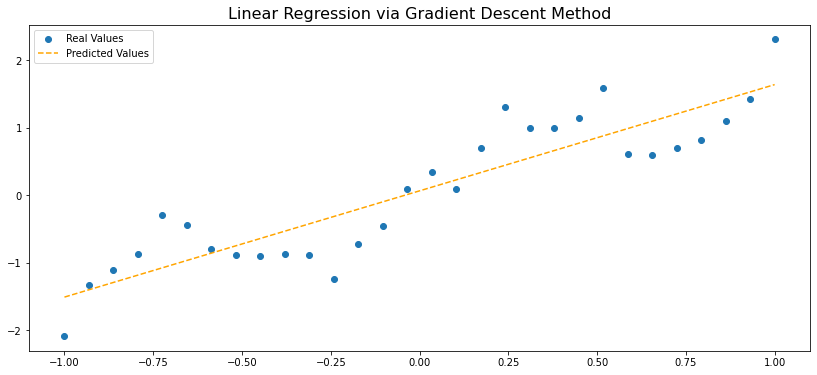

In [14]:
fig = plt.figure(figsize=(14, 6))
plt.title('Linear Regression via Gradient Descent Method', fontsize=16)
plt.scatter(X[:, 1], y, label = 'Real Values')
plt.plot(X[:, 1], y_pred, c='orange', linestyle='--', label = 'Predicted Values')
plt.legend()
plt.show()

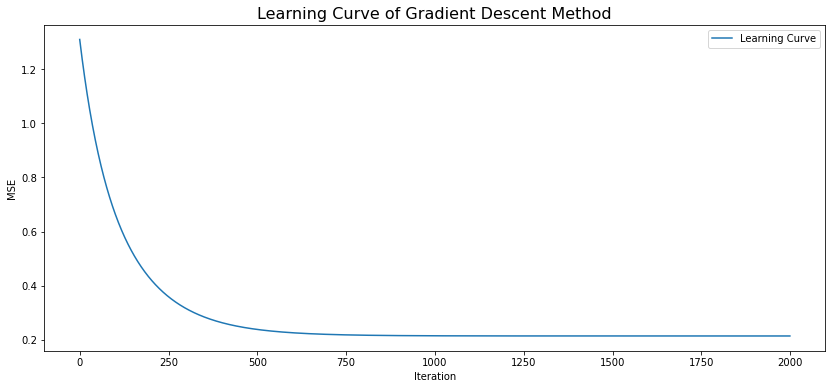

In [15]:
fig = plt.figure(figsize=(14, 6))
plt.title('Learning Curve of Gradient Descent Method', fontsize=16)
plt.plot(learning_curve_gd, label='Learning Curve')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.legend()
plt.show()

## Item c) Stochastic Gradient Descent
Show the model parameters, the MSE and the learning curve obtained by Stochastic Gradient Descent method. Plot the result line over the data.

In [16]:
# TODO - CORRIGIR ITERAÇÕES DO SGD
X = np.hstack([np.ones((data.shape[0], 1)), data[:, [0]]])
y = data[:, [1]]

In [17]:
my_lr = MyLinearRegression()
my_lr.fit_sgd(X, y, alpha=0.01, n_iterations=2000) # Stochastic Gradient Descent
y_pred = my_lr.predict(X)
learning_curve_sgd = my_lr.learning_curve
my_lr.print_parameters()

print('\n#--- Metrics ---#')
print('MSE:', get_mse(y, y_pred))
print('RMSE:', get_rmse(y, y_pred))

Intercept:	0.027689
X(1):    	1.568872

#--- Metrics ---#
MSE: 0.21500802345995013
RMSE: 0.4636895766134388


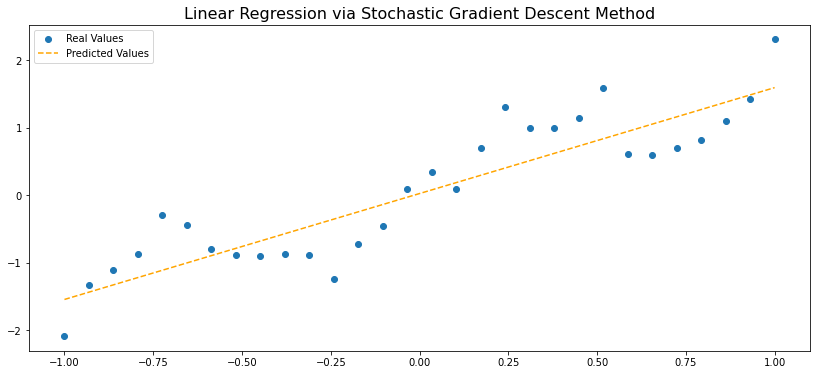

In [18]:
fig = plt.figure(figsize=(14, 6))
plt.title('Linear Regression via Stochastic Gradient Descent Method', fontsize=16)
plt.scatter(X[:, 1], y, label = 'Real Values')
plt.plot(X[:, 1], y_pred, c='orange', linestyle='--', label = 'Predicted Values')
plt.legend()
plt.show()

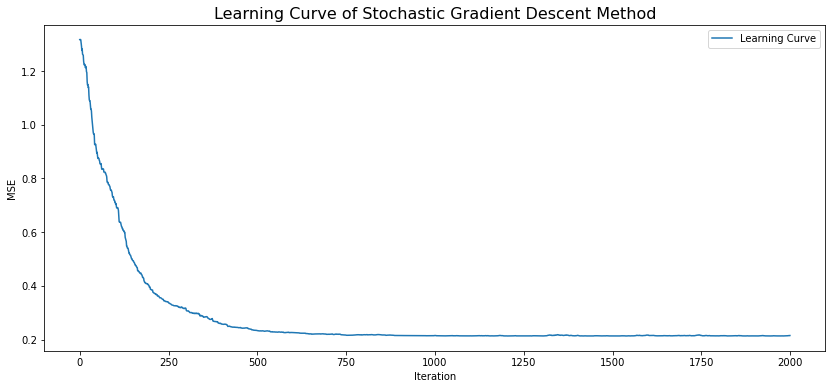

In [19]:
fig = plt.figure(figsize=(14, 6))
plt.title('Learning Curve of Stochastic Gradient Descent Method', fontsize=16)
plt.plot(learning_curve_sgd, label='Learning Curve')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.legend()
plt.show()

## GD x SGD - Learning Curves Compare

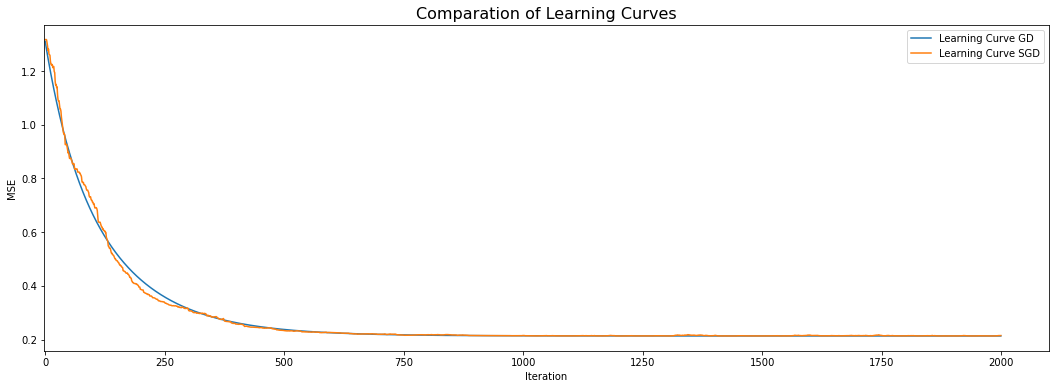

In [20]:
fig = plt.figure(figsize=(18, 6))
plt.title('Comparation of Learning Curves', fontsize=16)
plt.plot(learning_curve_gd, label='Learning Curve GD')
plt.plot(learning_curve_sgd, label='Learning Curve SGD')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.xlim(-2)
plt.legend()
plt.show()